In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Development of a Jukes-Cantor pipeline for generation of synthetic data

## Graph functions

In [181]:
# Function to calculate the weight of a tree split
def get_split_weight(n_L, n_R):
    '''
    Params:
        n_L, n_R : int
            Number of leaves in the left and right
            subtrees, respectively, that would result
            from the proposed split.
    Output:
        Returns the weight of the split as the amount 
        of subsequent splits that can be performed on
        the resulting subtrees:
        
            max(1, floor(n_L / 2)) * floor(n_R / 2)
            
        This results stems from removing isomorfisms
        from the possible splits, by imposing that the 
        main branches of any tree have to be ordered 
        by amount of leaves from left to right. Thus,
        n_L <= n_R.
    '''
    # Check that the constraint is fulfilled
    if np.any(n_L > n_R):
        print('Error: n_L cannot be larger than n_R.')
        return 

    n_L_term = np.clip(np.floor(n_L/2), a_min=1, a_max=n_R) 
    n_R_term = np.clip(np.floor(n_R/2), a_min=1, a_max=n_R)
    return (n_L_term * n_R_term).astype('int')


# Function to sample a split from a number of leaves
def sample_split(n_leaves):
    '''
    Params:
        n_leaves : int
            Number of current leaves in the tree to be 
            split.
    Output:
        Returns a split that is sampled non-uniformly,
        where the probability of a given split is 
        proportional to the number of possible topologies
        that can be obtained from the split.
    '''
    # Define all possible splits
    n_L = np.arange(int(np.floor(n_leaves/2))) + 1
    n_R = n_leaves - n_L

    # Get weights and probabilities
    w = get_split_weight(n_L, n_R)
    p = w / np.sum(w)

    # Sample one split
    idx = np.random.choice(np.arange(len(n_L)), p=p)
    split = [n_L[idx], n_R[idx]]

    return split
    

# Function for sampling binary tree toplogies non-uniformly
# but in a guided manner
def sample_biased_topology(n_leaves, seed=None):
    '''
    Params:
        n_leaves : int
            Number of leaves for the tree, must be greater
            than 1.
        seed : int (optional)
            Seed for the numpy random generator, not used
            by default.
    Output:
        Returns a rooted binary tree with the amount of 
        specified leaves, with a topology sampled 
        non-uniformly at random from the space of all 
        possible configurations up to isomorfism. The 
        topology is returned as nested tuple.
        
        The sampling is performed so that each sub-tree
        is sampled uniformly. This sampling is supposed to
        be used in an exploratory manner, to get all the 
        unique topologies with as little samples as possible.
    '''
    # Initialize seed if given
    if seed != None:
        np.random.seed(seed)

    # If 3 or less leaves are left, then return the
    # trivial structures
    if n_leaves == 1:
        return 1
    elif n_leaves == 2:
        return [1, 1]
    elif n_leaves == 3:
        return [1, [1, 1]]
        
    # Else, initialize tree topology
    top = []

    # Perform a split
    n_L, n_R = sample_split(n_leaves)

    # Operate recursively until all leaves are asigned
    top = [sample_biased_topology(n_L), 
           sample_biased_topology(n_R)]
    return top


# Function to turn a topology into a Graph object
def topology_to_graph(top):
    '''
    Params:
        top : array
            Nested tuple indicating the topology of a 
            binary tree.
    Output:
        Returns a networkx Graph object built from the
        specified topology.
    '''
    # Turn topology into string
    str_top = str(top)

    # Remove ones
    str_top = str_top.replace('1', '[]')

    # Evaluate to get nested tuple
    nested = eval(str_top)

    # Get Graph obejct and return
    graph = nx.from_nested_tuple(nested)
    return graph

## Jukes-Cantor model functions

In [321]:
# Function to define a JC transition matrix for a given set
# of parameters
def M_JC(t, alpha=1.):
    '''
    Params:
        t : float
            Length of the edge between the parent and child
            nodes. Must be non-negative.
        alpha : float (optional)
            Jukes-Cantor transition rate parameter. Default 
            values is 1.
    Output:
        Returns a numpy array of shape (4,4) with the values
        for the transition matrix of the Jukes-Cantor model,
        over an edge of length t.
    '''
    # Define term a(t)
    a_t = (3/4) * (1 - np.exp(-4 * alpha * t / 3))
    
    # Init matrix from non-diagonal terms
    M = np.ones((4,4)) * a_t / 3

    # Set diagonal elements and return
    np.fill_diagonal(M, val=1-a_t)
    return M


# Function to generate a sequence uniformly at
# random
def draw_uniform_sequence(m, chars, seed=None):
    '''
    Params:
        m : int
            Number of characters in the sequence.
        chars : array
            List of the characters that may be used when
            building the sequence.
        seed : int (optional)
            Seed for the numpy random number generator.
            Not used by default.
    Output:
        Returns a sequence drawn uniformly at random 
        from the space of all possible sequences with
        length m and with the given possible characters.
    '''
    # Init seed if given
    if seed != None:
        np.random.seed(seed)
        
    # Draw m characters
    seq_chars = np.random.choice(chars, size=m)

    # Concatenate into a single string and return
    seq = ''.join(seq_chars)
    return seq
    

# Function to turn a string sequence into a matrix 
# representation according to a specific vocabulary
def str_to_matrix(sequence, vocab):
    '''
    Params:
        sequence : str
            Sequence of characters.
        vocab : dict
            Dictionary with the numerical mapping of the 
            sequence characters.
    Output:
        Returns a matrix representation of shape (k,l) of
        the given sequence, where k is the length of the
        sequence and l is the number of characters in the
        vocabulary.
    '''
    # Init matrix
    A = np.zeros(shape=(len(sequence), len(vocab)))

    # Fill the matrix and return
    for i, c in enumerate(sequence):
        A[i, vocab[c]] += 1
    return A


# Function to draw a new random sequence from a parent, based 
# on the JC model
def draw_JC_sequence(parent_seq, vocab, t_e, alpha=1, seed=None):
    '''
    Params:
        parent_seq : str
            Sequence of characters of the parent node.
        vocab : dict
            Dictionary with the numerical mapping of the 
            sequence characters.
        t_e : float
            Length of the edge between the parent and child
            nodes. Must be non-negative.
        alpha : float (optional)
            Jukes-Cantor transition rate parameter. Default 
            values is 1.
        seed : int (optional)
            Seed for the numpy random number generator. Not 
            used by default.
    Output:
        Returns a new sequence for a child of the given 
        parent, drawn with the JC model based on an edge
        length t_e and transition rate alpha.
    '''
    # Init seed if given
    if seed != None:
        np.random.seed(seed)
        
    # Get matrix representation of the parent sequence
    P_0 = str_to_matrix(parent_seq, vocab)

    # Initialize transition matrix
    M_t = M_JC(t_e, alpha=alpha)

    # Get probabilities with Einstein summation
    P = np.einsum('ki,ij->kj', P_0, M_t)

    # Draw new sequence based on the resulting probabilities
    new_seq = []
    for i in range(len(parent_seq)):
        new_char = np.random.choice(list(vocab), p=P[i,:])
        new_seq.append(new_char)

    # Join characters and return
    new_seq = ''.join(new_seq)
    return new_seq

## Visualization

In [271]:
# Function to calculate the positions of the nodes
# in a tree for display
def get_tree_node_positions(G, dx, dy, dx_decay):
    '''
    Params:
        G : networkx Graph
            Graph representing a rooted binary tree.
        dx : float
            Horizontal displacement factor between sister 
            branches. Must be grater than 0.
        dy : float
            Vertical displacement factor between parent
            and child branches. Must be greater than 0.
        dx_decay : float 
            Horizontal displacement decay factor. It
            rescales dx depending on the depth of the 
            branches. Must be greater than 0.
    Output:
        Returns a dictionary with the positions of each
        node in the tree, required for a correct
        visualization of the topology.
    '''
    # Store nodes and node neighbors
    nodes = np.array(G.nodes)
    adj = [(n, nbrdict) for n, nbrdict in G.adjacency()]
    n_neigh = np.array([len(a[1]) for a in adj])

    # Rebuild adjacency as a dict
    adj = {a[0]:list(a[1].keys()) for a in adj}

    # Get root
    rho = int(nodes[n_neigh == 2][0])

    # Init node positions and depth
    n_pos = {rho: [0,0]}
    n_depth = [[rho]]

    # Initialize explored nodes
    n_explored = [rho]

    # Gather remaining node information and assign positions
    current_depth = 0
    while len(n_explored) < len(nodes):
        # Get all the children of the current layer 
        children = []
        parent_map = dict()
        for n in n_depth[current_depth]: 
            c_list = [c for c in adj[n] if not c in n_explored]
            children.extend(c_list)
            # Get map to parents
            for i, c in enumerate(c_list):
                parent_map[c] = [n, 2*i-1]

        # Get children positions based on parents
        for c in children:
            # Retrieve parent position
            px, py = n_pos[parent_map[c][0]]
            # Get relative position
            rel_x = parent_map[c][1]
            # Register child position
            cx = px + dx * (dx_decay ** current_depth) * rel_x
            cy = py - dy
            n_pos[c] = [cx, cy]
        
        # Add children to the explored nodes and depth 
        n_explored.extend(children)
        n_depth.append(children)
        
        # Increase depth
        current_depth += 1
        
    return n_pos


# Function to visualize a rooted binary tree
def visualize_tree(G, node_size, path=None,
                   dx=1, dy=1, dx_decay=0.5):
    '''
    Params:
        G : networkx Graph
            Graph representing a rooted binary tree.
        node_size : float
            Size of the nodes in the plot.
        path : str (optional)
            File to save the resulting image. Not used by
            default.
        dx : float (optional)
            Horizontal displacement factor between sister 
            branches. Must be grater than 0. Default is 1.
        dy : float (optional)
            Vertical displacement factor between parent
            and child branches. Must be greater than 0.
            Default is 1.
        dx_decay : float (optional)
            Horizontal displacement decay factor. It
            rescales dx depending on the depth of the 
            branches. Must be greater than 0. Default is
            0.5.
    Output:
        Produces a plot with the topology of the given
        tree.
    '''
    # Get node positions
    n_pos = get_tree_node_positions(G, dx, dy, dx_decay)

    # Init figure
    fig, ax = plt.subplots(figsize=(5,3), nrows=1, ncols=1,
                          dpi=200)

    # Plot graph
    nx.draw(G, pos=n_pos, ax=ax, node_size=node_size)

    plt.tight_layout()
    # Save if requested
    if path != None:
        plt.savefig(path, dpi=200)
    plt.show();

## Testing 

### Checking the correct behavior of our graph generation pipeline

In [169]:
# Let's check that our topology sampler works properly under the imposed 
# constraints, for small values of n:
# Set overall seed
np.random.seed(42)

# Get samples
N = 10
N_samples = int(1e6)
samples = [str(sample_biased_topology(N)) for i in range(N_samples)]
samples = pd.Series(samples)

# Get unique counts
unique_counts = list(samples.value_counts())
num_unique = len(unique_counts)

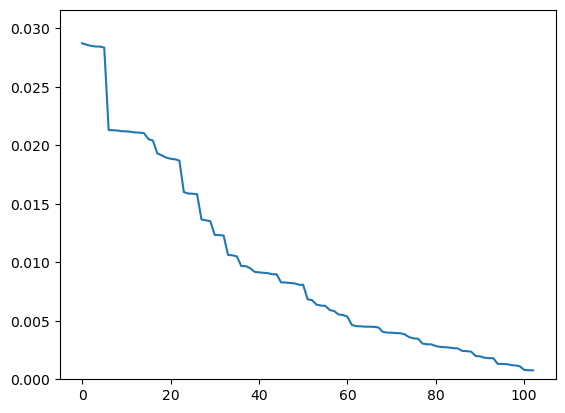

In [170]:
# Plot results
plt.plot(np.arange(num_unique), np.array(unique_counts) / N_samples)
plt.ylim(bottom=0, top = 1.1 * np.max(unique_counts) / N_samples);

In [254]:
# Let's sample one tree and visualize its topology
test_tree = sample_biased_topology(n_leaves=10, seed=1234)
test_graph = topology_to_graph(test_tree)

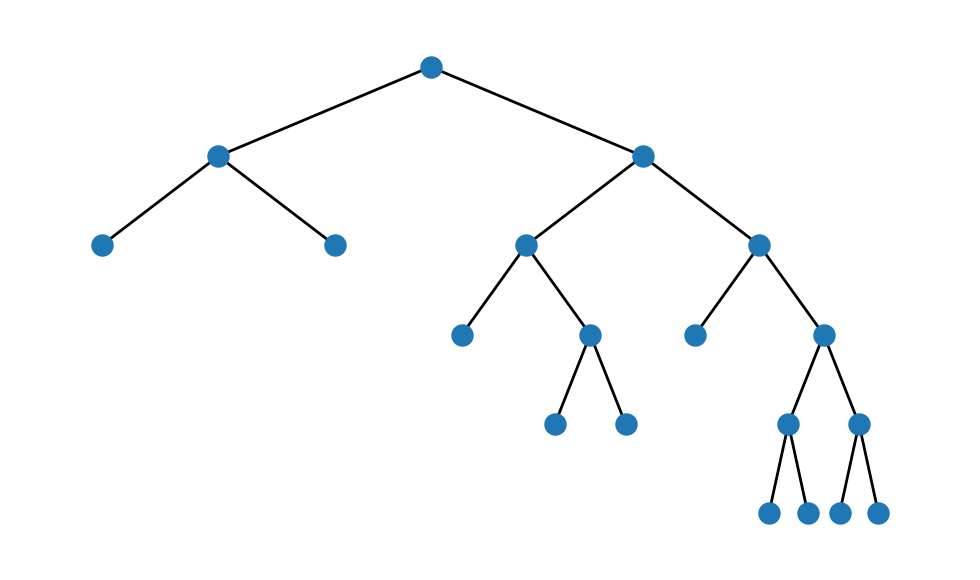

In [272]:
#nx.draw_planar(test_graph)
visualize_tree(test_graph, node_size=50, dx_decay=0.55,
               path='../Figures/test_tree_display_n_10.png')

### Checking the correct behavior of the JC generative process

In [299]:
# Let's check that the JC transition matrix is correct
M_jc_test = M_JC(1)
print(M_jc_test)
print(np.sum(M_jc_test, axis=1))

[[0.44769785 0.18410072 0.18410072 0.18410072]
 [0.18410072 0.44769785 0.18410072 0.18410072]
 [0.18410072 0.18410072 0.44769785 0.18410072]
 [0.18410072 0.18410072 0.18410072 0.44769785]]
[1. 1. 1. 1.]


In [312]:
# Define a vocabulary for testing
DNA_vocab = {'A': 0, 'G': 1, 'C': 2, 'T': 3}

# Uniformly draw a random sequence for our root
test_root_seq = draw_uniform_sequence(m=10, chars=list(DNA_vocab), seed=1234)

print('Root sequence:', test_root_seq)
print('Matrix representation:')
print(str_to_matrix(test_root_seq, DNA_vocab))

Root sequence: TTCGAAAGTG
Matrix representation:
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


In [327]:
# Check for correct JC sampling 
t_e = 0.3
test_child_seq = draw_JC_sequence(test_root_seq, DNA_vocab, t_e=t_e,
                                 seed=1234)
print(f'Child sequence from a JC process with t_e = {t_e}')
print(test_child_seq)

Child sequence from a JC process with t_e = 0.3
CTCGGAAGTC
